In [199]:
%pylab inline
import instr_vt_poleres as ivp

Populating the interactive namespace from numpy and matplotlib


/Users/goios/Envs/unsw/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['psd', 'mod', 'f', 'csd', 'qr', 'gamma']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [200]:
def perturbation(t):
    if t<0:
        return 0
    if t<1:
        #return (1-cos(pi*t))/2
        return t
    return 1


gamma = 0.0
zeta = .5


fr = 1500
qr = 5
ar = 5

fac = np.array([100])
qac = np.array([20])
aac = np.array([1])

fvt = np.array([500])
qvt = np.array([5])
avt = np.array([.1])

nlfunc = ivp.nlstiff_parabolic(x_st=.8,x_ev=1.2)
tmax = .3

pert_mult = 1.1
pert_duration = .0001

gamma_lim = gamma*1.1
tau = .1
gamma_t = lambda t: (1-np.exp(-t/tau))*gamma_lim


cs=ivp.croak_poleres(gamma=gamma_t,zeta=zeta,
                     fr=fr,qr=1,ar=1,
                     f1=fac,q1=qac,a1=aac,
                     fv=fvt,qv=qvt,av=avt,
                     nlfunc=nlfunc)
cs.gamma_vec=[]
cs.zeta_vec=[]
cs.perturbation_on=False

cs.set_tmax(tmax)
cs.set_initial_state(x0=0.,v0=0.,p0=0.,dp0=0.)
cs.setup_integrator()


# while cs.odesol.t <= cs.tmax and not cs.error:
#     newt = cs.cur_t+cs.dt
#     if cs.gamma(newt)>gamma and not cs.perturbation_on:
#         cs.perturbation_on = True
#         cs.pert_time = newt
#     if cs.perturbation_on:  
#         pert_mult_t = 1+(perturbation((newt-cs.pert_time)/pert_duration))*(pert_mult-1)
#         cs.gamma = lambda t: gamma*pert_mult_t
#         #cs.zeta = zeta*pert_mult_t
#     cs.calculate_at_time(newt)
#     cs.gamma_vec.append(cs.gamma(newt))
#     cs.zeta_vec.append(cs.zeta)

# cs.finish_simulation()
# cs.gamma_vec=np.array(cs.gamma_vec)
# cs.zeta_vec=np.array(cs.zeta_vec)



In [201]:
from matplotlib.mlab import psd, csd

def tfe(x, y, *args, **kwargs):
    """estimate transfer function from x to y, see csd for calling convention"""
    c,fc = csd(y, x, *args, **kwargs) 
    p,fp = psd(x, *args, **kwargs)
    return c/p,fc



In [223]:
from scipy.integrate import ode
from functools import partial
import sympy as sy
from sympy.parsing.sympy_parser import parse_expr


def odeint(f,y0,t,nsteps=500):
    odesol = ode(f=f)
    odesol.set_integrator('zvode',nsteps=nsteps)
    odesol.set_initial_value(y0,t[0])
    
    sol = [y0]
    for tt in t[1:]:
        if odesol.successful():
            this_sol = odesol.integrate(tt)
            sol.append(this_sol)
        else:
            sys.stderr.write('!!!!! Integration STOPPED prematurely!\n')
            sys.stderr.write('Return code: %d\n'%odesol.get_return_code())
            break
    return np.array(sol)

def impulse_responses(cs,t_max=1.0, impulse_duration=None,
                      impulse_function="(sin((x-x0)*pi/duration))*pi/2/duration"):

    if impulse_duration is None:
        impulse_duration = cs.dt/2
        
    base_expr = parse_expr(impulse_function)

    t_start = 0.0
    t_end = t_start + impulse_duration


    base_expr = base_expr.subs({'duration':impulse_duration,'x0':t_start})
    print(sy.N(sy.Integral(base_expr,('x',0,impulse_duration))))

    fsy = sy.lambdify('x',base_expr)
    
    n_total_modes = cs.nmodes + cs.nvtmodes
    y0 = np.zeros(n_total_modes,dtype='complex')

    def f(t,x):
        if t < t_end:
            u = fsy(t)
        else:
            u = 0.0
        y = np.zeros(n_total_modes,dtype='complex')
        for ii,mode in enumerate(cs.acmode+cs.vtmode):
            y[ii] = mode.calc_dp(u,x[ii]) 
        return y
        
    
    y1 = y0
    t1 = np.linspace(t_start,t_end,100)
    sol1 = odeint(f,y1,t1)
    force1 = fsy(t1)
    #idt = np.median(np.mean(np.diff(t1)))
    idt=cs.dt

    y2 = sol1[-1]

    t2 = np.arange(t_end,t_max,cs.dt)
    sol2 = odeint(f, y2, t2)
    force2 = np.zeros(t2.shape)

    t = np.concatenate((t1,t2))
    y = np.concatenate((sol1,sol2))
    force = np.concatenate((force1,force2))

    t_out = np.arange(0,t_max,idt)
    y_out = []
    f_out = []
    for ii in range(y.shape[1]):
        yi = y[:,ii]
        y_out.append(np.interp(t_out,t,2*np.real(yi)))
        fi = force
        f_out = np.interp(t_out,t,fi)
    return np.vstack(y_out).T, f_out, 1/idt, 

def impedances(cs, t_max=1.0, impulse_duration=None,
                impulse_function="(sin((x-x0)*pi/duration))*pi/2/duration"):
    y_ir, force, sr = impulse_responses(cs, t_max=t_max, 
                             impulse_duration=impulse_duration, 
                             impulse_function=impulse_function)
    fy = np.fft.fft(y,axis=0)
    fx = np.fft.fft(x)
    return fy/np.tile(fx[:,np.newaxis],(1,fy.shape[2])), np.arange(len(fx))/len(fx)*sr

In [224]:
y,f,sr=impulse_responses(cs,impulse_duration=.0000001)

1.00000000000000


In [225]:
len(y)

150000

(0.0, 100.0)

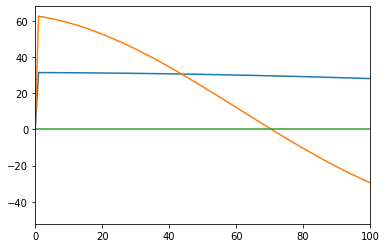

In [226]:
figure()
plot(y)
plot(f)
xlim(0,100)

(0.0, 2000.0)

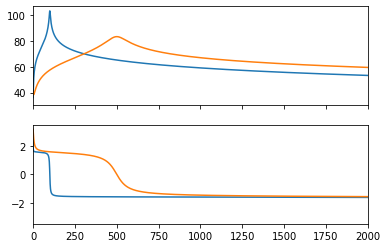

In [227]:
fig,ax = plt.subplots(2,sharex=True)
f=np.arange(0,y.shape[0])/y.shape[0]*sr
ax[0].plot(f,np.abs(20*np.log10(fft.fft(y,axis=0))))
ax[1].plot(f,np.angle(fft.fft(y,axis=0)))
xlim(0,2000)

In [228]:
fz=np.linspace(0,2000,1000)
jomega = 1j*2*pi*fz

(0.0, 1000.0)

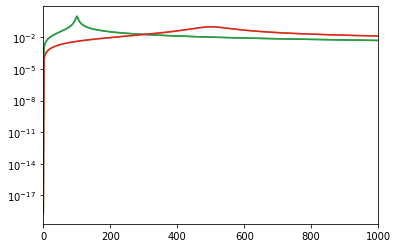

In [229]:
fy=np.fft.fft(y,axis=0)/y.shape[0]
semilogy(np.abs(fy))
mod=cs.acmode[0]
zbn = (mod.c/(mod.s-jomega))
zbc = (mod.c.conj()/(mod.s.conj()-jomega))
zb=zbc+zbn
mod=cs.vtmode[0]
zvn = (mod.c/(mod.s-jomega))
zvc = (mod.c.conj()/(mod.s.conj()-jomega))
zv=zvc+zvn
semilogy(fz,np.abs(zb))
semilogy(fz,np.abs(zv))

xlim(0,1000)

(0.0, 1000.0)

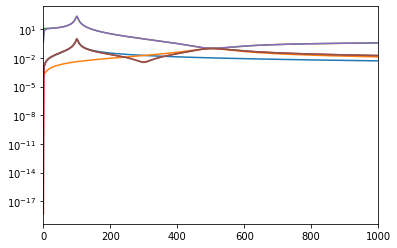

In [230]:
fy=np.fft.fft(y,axis=0)/y.shape[0]
semilogy(np.abs(fy))
mod=cs.acmode[0]
zbn = (mod.c/(mod.s-jomega))
zbc = (mod.c.conj()/(mod.s.conj()-jomega))
zb=zbc+zbn
mod=cs.vtmode[0]
zvn = (mod.c/(mod.s-jomega))
zvc = (mod.c.conj()/(mod.s.conj()-jomega))
zv=zvc+zvn
semilogy(fz,np.abs(zb/zv))
semilogy(fz,np.abs(zb+zv))

semilogy(np.abs(fy[:,0]/fy[:,1]))
semilogy(np.abs(fy[:,0]+fy[:,1]))
xlim(0,1000)

(-15.707963267948962+628.1221504879022j)
[31.41592654+0.j  0.        +0.j]
31.415926535897935
(15.707963267948964+0.39282185771601147j) (-15.707963267948967+628.1221504879024j)
(-314.15926535897927+3125.845222828293j)
[ 6.28318531e+01+0.j -3.63797881e-12+0.j]
62.83185307179586
(31.415926535897928+3.1574194169982763j) (-314.1592653589793+3125.8452228282936j)


<ipython-input-231-6c81e8a9c11b>:14: RuntimeWarning: invalid value encountered in true_divide
  semilogy(fz,np.abs(zb2/zv2))


(0.0, 1000.0)

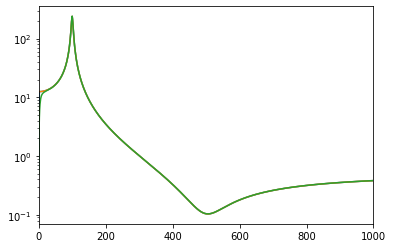

In [231]:
figure()
semilogy(fz,np.abs(zb/zv))
mod=cs.acmode[0]
omegar = 2*np.pi*mod.f
zb2 = omegar*(mod.a)/mod.q*jomega**1/(jomega**2+jomega*omegar/mod.q+omegar**2)
print(np.roots([1,omegar/mod.q,omegar**2])[0])
print(polymul([mod.c],[1,-mod.s.conj()])+polymul([mod.c.conj()],[1,-mod.s]))
print(omegar*(mod.a/mod.q))

print(mod.c,mod.s)
mod=cs.vtmode[0]
omegar = 2*np.pi*mod.f
zv2 = omegar*(mod.a)/mod.q*jomega**1/(jomega**2+jomega*omegar/mod.q+omegar**2)
semilogy(fz,np.abs(zb2/zv2))
print(np.roots([1,omegar/mod.q,omegar**2])[0])
print(polymul([mod.c],[1,-mod.s.conj()])+polymul([mod.c.conj()],[1,-mod.s]))
print(omegar*(mod.a/mod.q))

print(mod.c,mod.s)

semilogy(np.abs(fy[:,0]/fy[:,1]))
xlim(0,1000)

In [232]:
print(polydiv([omegar*(mod.a/mod.q),0],[1,-mod.s]))
print(polydiv([omegar*(mod.a/mod.q),0],[1,-mod.s.conj()]))


(array([62.83185307+0.j]), array([-19739.20880218+196402.64776592j]))
(array([62.83185307+0.j]), array([-19739.20880218-196402.64776592j]))


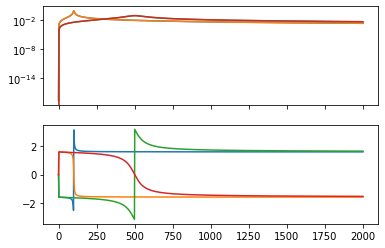

In [233]:
fig,ax=subplots(2,sharex=True)
for z in [zb,zb2,zv,zv2]:
    ax[0].semilogy(fz,np.abs(z))
    ax[1].plot(fz,np.angle(z))

In [213]:
polyadd(polymul([mod.c.conj()],[1,mod.s.conj()]),polymul([mod.c],[1,mod.s]))

array([    62.83185307+0.j, -39478.41760436+0.j])

In [214]:
polymul([1,-mod.s],[1,-mod.s.conj()])

array([1.00000000e+00+0.j, 6.28318531e+02+0.j, 9.86960440e+06+0.j])

In [215]:
mod.w/mod.q*mod.a

62.831853071795855

In [216]:
mod.w**2

9869604.401089357

In [217]:
polyadd(polymul([cs.cr.conj()],[1,cs.sr.conj()]),polymul([cs.cr],[1,cs.sr]))

array([       0.        +0.j, 88826439.60980423+0.j])

In [218]:
polymul([1,-cs.sr],[1,-cs.sr.conj()])

array([1.00000000e+00+0.j, 9.42477796e+03+0.j, 8.88264396e+07+0.j])

In [ ]:
sy.solve(dzexpr,w)

In [ ]:
sy.nsolve(dzexpr,w,10,verify=False)

In [ ]:
sy.plot(dzexpr,(w,50,300))

In [ ]:
def f(x,f=100,q=10,a=1):
    omegar=2*pi*f
    s = 1j*x*2*pi
    fs = (a*omegar*q)**2*s**1/(s**2+s*omegar/q+omegar**2)
    return(np.abs(fs))

from scipy.optimize import fmin

fsrch = lambda x: -f(x,f=100)-f(x,f=200,q=10,a=.1)

xmax=fmin(fsrch ,300)
print(xmax)
semilogy(-fsrch(np.linspace(0,1000,1000)))
axvline(xmax)

In [ ]:
from scipy.optimize import minimize_scalar
minimize_scalar(fsrch,bounds=(0,200))

In [ ]:
minimize_scalar(fsrch,bounds=(100,300))

In [ ]:
from scipy.signal import find_peaks, find_peaks_cwt
find_peaks(-fsrch(np.linspace(0,1000,1000)),width=0)

In [ ]:
find_peaks?

In [ ]:
fmin(fsrch,192)

In [ ]:
plot(diff(diff(fsrch(np.linspace(0,1000,1000)))))